# Исследование надёжности заёмщиков

Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Такое исследование может помочь при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## 1 Шаг. Откроем файл с данными и изучим общую информацию

Импортируем необходимые библиотеки

In [86]:
import pandas as pd

Прочитаем данные в переменную `data`

In [87]:
data = pd.read_csv('/datasets/data.csv')

### Исследуем названия признаков

In [88]:
_ = [print('"{}"'.format(x)) for x in data.columns]

"children"
"days_employed"
"dob_years"
"education"
"education_id"
"family_status"
"family_status_id"
"gender"
"income_type"
"debt"
"total_income"
"purpose"


Названия признаков оформлены корректно - змеиный регистр, нет лишних символов

### Посмотрим на общие сведения о датафрейме

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


1. Мы имеем датафрейм размерностью 12 х 21525. В нём содержатся данные типа int64, float64 и object (str). 
2. Присутствуют пропуски в признаках days_employed и total_income, в обоих признаках пропущено 2174 значения.  

Проверим, в одних и тех же или в разных строках пропущены значения

In [90]:
data[(data['days_employed'].isna() == True) & (data['total_income'].isna() == True)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Да, общий трудовой стаж и ежемесячный доход содержат пропуски в одних и тех же строках.  
Возможно, при состоавлении датафрейма клиенты банка отказались называть свой доход и стаж 
по тем или иным причинам. Т.е. вероятно это пропуски типа MAR.  
Как вариант, можно связаться с сотрудниками банка и уточнить, возможна ли такая ситуация. 

Посмотрим на первые несколько строк датафрейма и сводную статистику

In [91]:
display(data.head(10))
display(data.describe())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Есть проблемы  с данными: 

* столбец children содержит отрицательные значения и значение 20
* столбец days_employed содержит отрицательные значения и сильно преувеличенные значения (трудовой стаж 401755 / 365 -    это 1100 лет)
* столбец dob_years таже содержит некорректные значения - возраст 0 не может быть
* столбец education с типом данных object не приведен к общему регистру, поправим в следующем шаге
* в остальных столбцах с первого взгляда некорректных значений не наблюдается

    Разберемся с каждым столбцом отдельно

### Признак "children" - количество детей у клиентов

Оценим, как распределены клиенты банка по количеству детей

In [92]:
display(data.groupby(by='children')['children'].count().sort_values(ascending=False))

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

<AxesSubplot:>

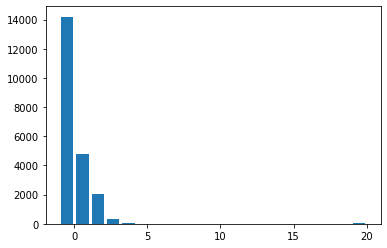

In [93]:
data.children.hist(bins=20, grid=False, rwidth=.8)

В среднем количество детей у клиентов банка колеблется от 0 до 5, но внезапно появляется цифра 20 и -1, 
что похоже на "вброс" или ошибку.
Вероятно, это ошибка связана с формированием или копированием датафрейма - у единицы 
появилось отрицательное значение, а "2" изменилась на "20". 
Тем более что в следующем столбце `"days_employed"` также существуют отрицательные значения 
в достаточно большом количестве.

Посмотрим остальные значения строк, где у клиентов банка -1 и 20 детей

In [94]:
display(data[data['children'] == -1].head(10))
display(data[data['children'] == 20].head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987.852217,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,NaN,57,Среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля
1363,-1,-1195.264956,55,СРЕДНЕЕ,1,женат / замужем,0,F,компаньон,0,69550.699692,профильное образование
1929,-1,-1461.303336,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,109121.569013,покупка жилья
2073,-1,-2539.761232,42,среднее,1,в разводе,3,F,компаньон,0,162638.609373,покупка жилья
3814,-1,-3045.290443,26,Среднее,1,гражданский брак,1,F,госслужащий,0,131892.785435,на проведение свадьбы
4201,-1,-901.101738,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375.766751,операции со своей недвижимостью


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля
3302,20,NaN,35,среднее,1,Не женат / не замужем,4,F,госслужащий,0,NaN,профильное образование
3396,20,NaN,56,высшее,0,женат / замужем,0,F,компаньон,0,NaN,высшее образование
3671,20,-913.161503,23,среднее,1,Не женат / не замужем,4,F,сотрудник,0,101255.492076,на покупку подержанного автомобиля
3697,20,-2907.910616,40,среднее,1,гражданский брак,1,M,сотрудник,0,115380.694664,на покупку подержанного автомобиля
3735,20,-805.044438,26,высшее,0,Не женат / не замужем,4,M,сотрудник,0,137200.646181,ремонт жилью


В этих строках сохранена важная информация о семейном положении и задолженности по возврату кредита, 
не будем их убирать (хотя их немного, можно и убрать)

Уберем знак у -1, а 20 изменим на 2 в следующем шаге

### Признак "days_employed" - трудовой стаж в днях

Оценим данные признака через сводную статистику

In [95]:
data['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

Содержит как отрицательны значения, так и сильно преувеличенные значения. 

### Признак "dob_years" - возраст клиента в годах

Посмотрим какие возраста у клиентов банка и их частоты

In [96]:
data.groupby(by='dob_years')['dob_years'].count().sort_values(ascending=False)

dob_years
35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
22    183
66    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

<AxesSubplot:>

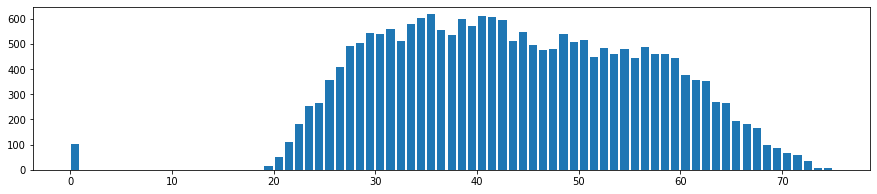

In [97]:
data.dob_years.hist(bins=data.dob_years.max(), grid=False, rwidth=.8, figsize=(15,3))

В основном кредиты берут от 20 до 70 лет, есть некорректные значения 0 у 101 клиента. 
Это может быть человеческая или техническая ошибка.

### Признак "education" - образование

Посмотрим, какие уникальные значения содежатся в данных признака

In [98]:
data['education'].sort_values().unique()

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

В данных есть дубликаты связанные с разным регистром букв в словах. Нужно будет привести их к единообразию.

### Признак "famili_status" - семейное положение

Определим, какие уникальные значения есть в признаке `"famili_status"`

In [99]:
data['family_status'].sort_values().unique()

array(['Не женат / не замужем', 'в разводе', 'вдовец / вдова',
       'гражданский брак', 'женат / замужем'], dtype=object)

Всего 5 значений, все записи корректные

### признак "gender" - пол клиента

Посмотрим как распределены клиенты по гендерному признаку

In [100]:
data.groupby(by='gender')['gender'].count().sort_values(ascending=False)

gender
F      14236
M       7288
XNA        1
Name: gender, dtype: int64

<AxesSubplot:>

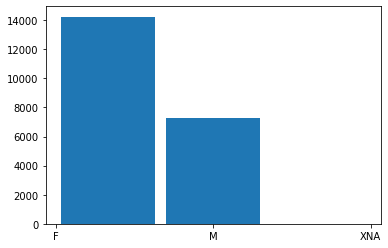

In [101]:
data.gender.hist(bins=3, grid=False, rwidth=.9)

Женщин в датафрейме в 2 раза больше чем мужчик, один из признаков XNA.  
В мире существует 54 пола (если верить поисковой выдаче Яндекса),  
но ни один из них не имеет такой аббирвиатуры. 

Взглянем на эту строку в датафрейме

In [102]:
data[data['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Это объект под номером 10701

### Признак "income_type" - тип занятости

Взглянем на уникальные значения

In [103]:
data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

Все ровно

### Признак "debt" - имел ли задолженность по возврату кредита

Посмотрим на уникальные значения признака

debt
0    19784
1     1741
Name: debt, dtype: int64

Должники - 8.09%


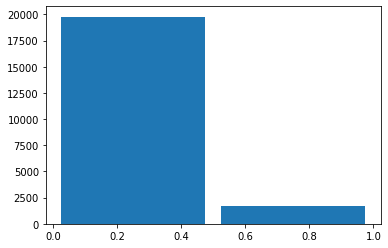

In [104]:
display(data.groupby(by='debt')['debt'].count().sort_values(ascending=False))
data.debt.hist(grid=False, bins=2, rwidth=.9)
print('Должники - {:.2%}'.format(data.debt.mean()))

8,09% из заемщиков имели проблемы по возврату кредита в срок

### Признак "total_income" - ежемесячный доход

В пункте 1.2 мы обнаружили пропуски в данном признаке и признаке рабочего стажа.    
Вероятно, при сборе данных клиенты банка воздержались в информировании  
о своём доходе и стаже работы потем или иным причинам - пропуски типа MAR.  
Исправим пропуске на следующем этапе - Предобработке данных.

2174

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

<AxesSubplot:>

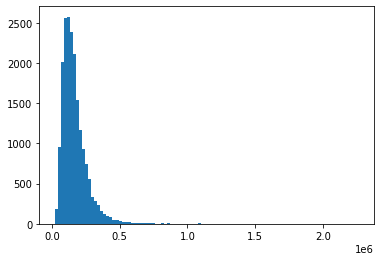

In [105]:
display(data['total_income'].isna().sum())

display(data['total_income'].describe())

data.total_income.hist(bins=100, grid=False)

### Признак "purpose" - цель получения кредита

Посмотрим на уникальные значения этого признака

In [106]:
data['purpose'].unique()

# в этом столбце можно использовать лемматизацию, чтобы можно было отсортировать данные. 
# в основном цели кредита можно разделить на:
#     приобретение или ремонт автомобиля
#     праздники (свадьба)
#     операции над недвижимостью
#     образование

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Признак содержит данные четырёх модальностей:
* приобретение или ремонт автомобиля
* праздники (свадьба)
* операции над недвижимостью
* обоазование

Возможно использовать лемматизацию, для сортировки признаков по этим 4-м модальностям.

**Вывод**

В таблице есть проблемы с данными, которые необходимо исправить перед дальнейшей работы с ней. Из выявленных проблем можно отметить:

а) пропуски значений (в total_income и days_employed). Вероятно это пропуски типа MAR, т.е. их изменение (не учитывание) не должно значимо повлиять на решение задачи. Решено заменить пропущенные значения на нулевые)

б) некорректные (отрицательные или сильно увеличенные) значения в столбцах children, days_employed, исправить знак и убрать 0. Технические ошибки (изменение знака), или человеческий фактор (например, не там поставили запятую).

в) в столбце dob_years есть некорректные значения - 0 в 101 ячейках, заменим их средним значением по столбцу (количественный признак). Тут скорее всего либо техническая ошибка.

г) в стоблце education нужно привести все значения к одному регистру (избавиться от дубикатов)

д) в столбце gender нужно исправить 1 значение

е) в столбце purpose разрозенные занчения можно привести в порядок посредством лемматизации

## 2 Шаг. Предобработка данных

### Обработка пропусков и неверных значений

Пропуски значений в `"total_income"` и `"days_employed"` заменим на среднее значение по признаку.

In [107]:
mean_total_income = data['total_income'].mean()

data['total_income'] = data['total_income'].fillna(value=mean_total_income)

mean_days_employed = data['days_employed'].mean()

data['days_employed'] = data['days_employed'].fillna(value=mean_days_employed)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Отрицательные значения исправим на положительные

Уберём из данных признаков `"children"`, `"days_employed"` и `"total_income"`  
отрицательные знаки - через модуль

In [108]:
data['children'] = data['children'].apply(lambda x: abs(x))

data['days_employed'] = data['days_employed'].apply(lambda x: abs(x))

data['total_income'] = data['total_income'].apply(lambda x: abs(x))

У клиентов с 20 детьми вероятно ошибка в обработке данных, уберём от 20 ноль, заменим на 2:

In [109]:
data.loc[data['children'] == 20, 'children'] = 2

В признаке `"dob_years"` исправим значение 0 на среднее значение по признаку  
(клиенту не может быть ноль лет)

In [110]:
data.loc[data['dob_years'] == 0, 'dob_years'] = data['dob_years'].mean()

В признаке `"total_income"` пропуски заменим на среднее значение  
(хотя, вероятно, они утаили свои доходы не потому что они низкие)

In [111]:
data['total_income'] = data['total_income'].fillna(value=data['total_income'].mean())

Исправим некорректное значение в признаке `"gender"` на F, таким образом  
мы сохраним данные. F - потому что женщин большое в датафрейме.

In [112]:
data.loc[10701, 'gender'] = 'F'

### Замена типа данных

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  float64
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


In [114]:
data['days_employed'] = data['days_employed'].astype(int)
data['dob_years'] = data['dob_years'].astype(int)
data['total_income'] = data['total_income'].astype(int)

# проверка
data['total_income'].isna().sum()

0

### Обработка дубликатов

Признак `"education"` - приведём все значения к нижнему регистру

In [115]:
data['education'] = data['education'].str.lower()

# проверим
_ = [print(x) for x in data['education'].unique()]

высшее
среднее
неоконченное высшее
начальное
ученая степень


#### Вывод

Заменены дубликаты с разными регистрами.
Дубликаты по всей таблице не абсолютные, отличаются семейным статусом и количеством детей, поэтому оставим их.

### Лемматизация

Подключим необходимые библиотеки

In [116]:
from pymystem3 import Mystem
from collections import Counter

In [117]:
# создадим объект Mystem

m = Mystem()

# создадим список всех текстовых значений столбца purpose и соединим их пробелом
text = ' '.join(data['purpose'])

# лемматизируем текст и выведем на экран посчитав частоты слов
lemmans = m.lemmatize(text)

_ = [print(x) for x in Counter(lemmans)]


покупка
 
жилье
приобретение
автомобиль
дополнительный
образование
сыграть
свадьба
операция
с
на
проведение
для
семья
недвижимость
коммерческий
жилой
строительство
собственный
подержать
свой
со
заниматься
сделка
получение
высокий
подержанный
профильный
сдача
ремонт




#### Вывод

т.е. кредиты беруться для следующих задач:

1) на покупку/приобретение/строительство жилья/недвижимости

2) на покупку/ремонт автомобиля

3) на образование

4) на свадьбу

### Категоризация данных

Чтобы ответить на вопрос *"влияет ли количество детей на факт погашения кредита в срок?"*, нужно 
определить какая часть из каждой категории людей имела задолжности. Для этого нужно количество задолжностей категории разделить на количество каждой категории

Для начала сгруппируем таблицу по признаку - поличество детей

In [118]:
data_group_children = data.groupby(by='children').count()

# возьмем series из сгруппированного датафрейма с суммой просрочек по уплате
total_debt_cat = data.groupby(by='children')['debt'].sum()
# и series с общим количеством клиентов 
count_debt_cat = data.groupby(by='children')['debt'].count()

# посмотрим на них
# display(count_debt_cat)
# display(total_debt_cat)

# добавим к сгруппированой сохраненной таблице эти колонки и новую, которая получится 
# при делении количество "задолженников" на общее количество

data_group_children['children_to_debt'] = 100 * total_debt_cat / count_debt_cat
data_group_children['total_debt_cat'] = total_debt_cat
data_group_children['count_debt_cat'] = count_debt_cat

# выведем сводную таблицу, те столбцы, которые нас интересуют
data_group_children.loc[:, ['total_debt_cat', 'count_debt_cat', 'children_to_debt']].sort_values(by='children_to_debt')


,total_debt_cat,count_debt_cat,children_to_debt
children,,,
5,0,9,0.000000
0,1063,14149,7.512898
3,27,330,8.181818
1,445,4865,9.146968
2,202,2131,9.479118
4,4,41,9.756098


In [119]:
# аналогичено сделаем с семейным положением. Категории у нас уже имеются (family_status)
# Сгруппируем по ним таблицу и сохраним в другую:

data_group_by_famili_status = data.groupby(by='family_status').count()
total_debt_famili_status = data.groupby(by='family_status')['debt'].sum()
count_debt_famili_status = data.groupby(by='family_status')['debt'].count()

data_group_by_famili_status['debt_family'] = 100 * total_debt_famili_status / count_debt_famili_status
data_group_by_famili_status['total_debt_famili_status'] = total_debt_famili_status
data_group_by_famili_status['count_debt_famili_status'] = count_debt_famili_status

data_group_by_famili_status.loc[:, ['total_debt_famili_status','count_debt_famili_status','debt_family']].sort_values(by='debt_family')

,total_debt_famili_status,count_debt_famili_status,debt_family
family_status,,,
вдовец / вдова,63,960,6.562500
в разводе,85,1195,7.112971
женат / замужем,931,12380,7.520194
гражданский брак,388,4177,9.288963
Не женат / не замужем,274,2813,9.740491


**Вывод**

Дети
Сам факт наличия детей снижает вероятность оплатить кредит в срок, при этом у заемщиков с 3-мя детьми ситуация по своевременному возврату чуть лучше (вероятно связано со льготами), но в целом отмечается тенденция что чем больше детей, тем меньше шансов оплаты кредита в срок.

Семейное положение
    Оказывается, семейное положение также влияет на вероятность оплаты кредита в срок:
    - самые высокие шансы оплатить кредит в срок у вдовца/вдовы
    - далее идут люди в разводе
    - после них женатые/замужние
    - предпоследние те, ко в гражданском браке
    - меньше всего шансов у не женатых/не замужних

## 3 Шаг. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Сам факт наличия детей снижает вероятность оплатить кредит в срок, при этом у заемщиков с 3-мя детьми ситуация по своевременному возврату чуть лучше (вероятно связано со льготами), но в целом отмечается тенденция что чем больше детей, тем меньше шансов оплаты кредита в срок.

**Вывод**

- Есть ли зависимость между семейным положением и возвратом кредита в срок?


Семейное положение

    Оказывается, семейное положение также влияет на вероятность оплаты кредита в срок:
    - самые высокие шансы оплатить кредит в срок у вдовца/вдовы
    - далее идут люди в разводе
    - после них женатые/замужние
    - предпоследние те, ко в гражданском браке
    - меньше всего шансов у не женатых/не замужних

**Вывод**

Дети
Сам факт наличия детей снижает вероятность оплатить кредит в срок, при этом у заемщиков с 3-мя детьми ситуация по своевременному возврату чуть лучше (вероятно связано со льготами), но в целом отмечается тенденция что чем больше детей, тем меньше шансов оплаты кредита в срок.

Семейное положение
    Оказывается, семейное положение также влияет на вероятность оплаты кредита в срок:
    - самые высокие шансы оплатить кредит в срок у вдовца/вдовы
    - далее идут люди в разводе
    - после них женатые/замужние
    - предпоследние те, ко в гражданском браке
    - меньше всего шансов у не женатых/не замужних

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Посмотрим диапазон доходов у клиентов (в месяц)

In [120]:
print(data['total_income'].max())
print(data['total_income'].min())

2265604
20667


Условно выделим категогии:

    1. < 50 тр
    2. 50-100 тр
    3. 100 - 300 тр
    4. > 300
    
Создадим функцию, которая будет определять к какой категории относится клиент по уровню дохода

In [121]:
def incom_lvl(total_income):
    if total_income < 50*10**3: 
        return '< 50'
    elif 50*10**3 <= total_income < 100*10**3: 
        return '50-100'
    elif 100*10**3 <= total_income <= 300*10**3: 
        return '100-300'
    else: 
        return '> 300'

Создадим новый столбец в таблице и заполним его категориальными данныхми с помощью функции

In [122]:
data['income_lvl'] = data['total_income'].apply(incom_lvl)

Создадим новый датафрейм где будут сгруппированы значения по новым категориям:

In [123]:
data_income = data.groupby('income_lvl').count()

# у основной массы клиентов доход от 100 до 300 тр/месяц. Посмотрим кто из них
# лучше платит по счетам

count_income = data.groupby(by='income_lvl')['debt'].count()
total_income = data.groupby(by='income_lvl')['debt'].sum()

# display(total_income)
# display(count_income)

data_income['income_debt'] = 100 * total_income / count_income


data_income.loc[:, ['income_debt']].sort_values(by='income_debt')


,income_debt
income_lvl,
< 50,6.182796
> 300,7.152497
50-100,8.090931
100-300,8.222080


**Вывод**

Лучше всего кредит оплачивают люди с небольшим заработком, наверное потому что им есть что терять.
Также люди с прибылью более 300 тр оплачивают кредит в срок.
А вот остальные показали наименьшие результаты.

- Как разные цели кредита влияют на его возврат в срок?

В пункте 2.4. мы получили такой вывод 

Counter({' ': 55201, 'недвижимость': 6367, 'покупка': 5912, 'жилье': 4473, 'автомобиль': 4315, 'образование': 4022, 'с': 2924, 'операция': 2610, 'свадьба': 2348, 'свой': 2235, 'на': 2233, 'строительство': 1881, 'высокий': 1375, 'получение': 1316, 'коммерческий': 1315, 'для': 1294, 'жилой': 1233, 'сделка': 944, 'дополнительный': 909, 'заниматься': 908, 'подержать': 858, 'проведение': 777, 'сыграть': 774, 'сдача': 653, 'семья': 641, 'собственный': 635, 'со': 630, 'ремонт': 612, 'приобретение': 462, 'профильный': 436, 'подержанный': 110, '\n': 1}) 

сделаем следующий вывод: люди брали кредит для следующих потребностей:

1. связанные с недвижимостью: [недвижимость, жилье]

2. Автомобиль: [автомобиль]

3. Образование: [образование]

4. Свадьба: [свадьба]

Т.о. у нас 4 категории

Опишем функцию, которая отнесет цель кредита к одной из 4х категорий:


In [124]:
# загрузим инструменты если вдруг еще не загружены
from pymystem3 import Mystem
from collections import Counter
m = Mystem()

# print(m.lemmatize('покупка жилья для семьи'))

def purpose_func(text):
    lemmans = m.lemmatize(text)
    if 'недвижимость' in lemmans:
        return 'недвижимость'
    elif 'жилье' in lemmans:
        return 'недвижимость'
    elif 'автомобиль' in lemmans:
        return 'автомобиль'
    elif 'образование' in lemmans:
        return 'образование'
    elif 'свадьба' in lemmans:
        return 'свадьба'

# категоризуем данные
data['purpose_func'] = data['purpose'].apply(lambda x: purpose_func(x))

# проверим все ли откатегоризованы
data['purpose_func'].isna().sum()

# и как это выглядит
# data.head(20)

# сгруппируем по новой колонке, создав новую таблицу
data_purpose = data.groupby(by='purpose_func').count()

total_debt_purpose = data.groupby(by='purpose_func')['debt'].sum()
count_debt_purpose = data.groupby(by='purpose_func')['debt'].count()

data_purpose['purpose_debt'] = 100 * total_debt_purpose / count_debt_purpose

data_purpose.loc[:, ['purpose_debt']].sort_values(by='purpose_debt')

,purpose_debt
purpose_func,
недвижимость,7.214022
свадьба,7.921635
образование,9.199403
автомобиль,9.339513


**Вывод**

Клиенты, берущие кредит на операции с недвижимостью, обладают самым высоким шансом уложиться с оплатой в срок

За ними идут клиенты, которым нужны деньги на проведение свадьбы

После них люди, с кредитом на образование

И хуже всего вероятность уложиться в срок у клиентов, чей кредит связан с операциями с авто

In [125]:
data.groupby(by='purpose_func')['debt'].mean()

purpose_func
автомобиль      0.093395
недвижимость    0.072140
образование     0.091994
свадьба         0.079216
Name: debt, dtype: float64

## Шаг. Общий вывод

Т.о. в результате анализа датасета от банка мы определили что наличие детей снижает вероятность уложиться по уплате в срок, женатые/замужние клиенты хуже справляются с оплатой, а вдовцы/вдовы наоборот оплачивают хорошо. Человек с доходами ниже 50 тыс рублей или выше 300 тыс. рублей лучше справиться с уплатой по счетам, чем те, кто зарабатывает иную сумму.

Итого: идеальный клиент - это вдовец с низкой зарплатой без детей, которому нужен кредит на ремонт жилья